In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

import cv2
import os
from sklearn.model_selection import train_test_split
import random
import glob
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense,Dropout,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.models import load_model

## Load Data
We will now get the filepaths of our images and append them to a 1D array. We will also get the steering data from the filename and append that to our labels array.

In [36]:
dataset = 'N64_Mario_Raceway'
#dataset = 'SNES_Mario_Circut_3'
images=[]
steering=[]

for folder in os.listdir(dataset):
    for img in os.listdir(os.path.join(dataset,folder)):
        images.append(os.path.join(dataset,folder,img))
        
        x_coord=float((int(img.split('_')[2]) - 960 ) / 960) # Normalize data, as screen width = 1920 remove 1 because zero indexed
        steering.append(x_coord)

## Visualise data
View our labels with matplotlib to check that they are balanced and that everything is working so far.

<BarContainer object of 35 artists>

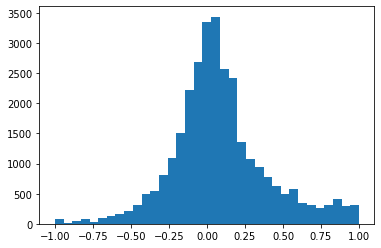

In [37]:
nBins=35
samplesPerBin=1000

hist,bins = np.histogram(steering,nBins)
center=(bins[:-1]+bins[1:])*0.5

plt.bar(center,hist,width=0.06)

## Split Data
We will split our data for training and testing

In [38]:
X_train,X_test,y_train,y_test=train_test_split(images,steering,test_size=0.05)
print(len(X_train),len(X_test))

28862 1520


## Setup Image Augmentation

In [57]:
def augmentImage(img,steering):
    img=mpimg.imread(img) # 820x400
    
    x = 60
    y = 30
    cv2.rectangle(img, (x, y), (x+80, y+40), (0,0,0), -1)
    
    # if random.randint(0,1) or False:
    #     img = iaa.Affine(translate_percent={'x':(-0.1,0.1),'y':(-0.1,0.1)}).augment_image(img)
        
    # if random.randint(0,1): 
    #     img = iaa.Affine(scale=(1,1.3)).augment_image(img)
    
    if random.randint(0,1):
        img = iaa.Multiply((0.6,1.2)).augment_image(img)
    
    if random.randint(0,1):
        img = cv2.flip(img,1)
        steering =- steering
    return img,steering

## Define Preprocessing Function

In [58]:
def preProcessing(img):
    img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)#[50:,:] # img[40:200,200:700]

    #img=cv2.resize(img,(200,66))
    img=img/255
    return img

## Create Batches

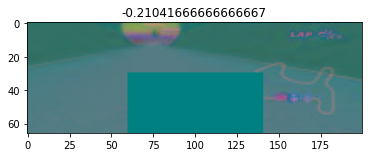

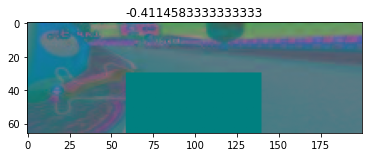

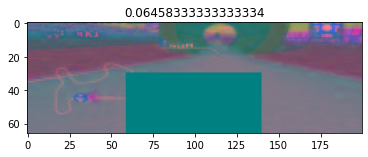

In [61]:
def create_batch(imagePath,steeringList,batch_size=32,augment=True):
  
    while True: # every time the generator object is called we repeat this
        imgBatch = []
        steeringBatch = []

        for i in range(batch_size):
            index=random.randint(0,len(steeringList)-1)
            img=imagePath[index]
            steering=steeringList[index]
            
            if augment:
                img, steering = augmentImage(img,steering)    
            else:
                img = mpimg.imread(img)
            
            img = preProcessing(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
            
        yield (np.asarray(imgBatch),np.asarray(steeringBatch))


        
test=create_batch(X_test,y_test,3,augment=True)

test=next(test)
plt.figure(1)
plt.title(test[1][0])
plt.imshow(test[0][0])

plt.figure(2)
plt.title(test[1][1])
plt.imshow(test[0][1])

plt.figure(3)
plt.title(test[1][2])
plt.imshow(test[0][2])

## Build Model


In [69]:
def createModel():
    model=Sequential()

    
    model.add(Convolution2D(24,(3,3),(2,2),input_shape=(66,200,3),activation='elu'))
    #model.add(Convolution2D(36,(5,5),(2,2),activation='elu'))
    model.add(Convolution2D(48,(3,3),(2,2),activation='elu'))
    model.add(MaxPooling2D((4,4),strides=(4,4)))
    model.add(Dropout(0.2))
    # model.add(Convolution2D(64,(3,3),activation='elu'))
    # model.add(Convolution2D(64,(3,3),activation='elu'))

    model.add(Flatten())
    
    model.add(Dense(100,activation='elu'))
    model.add(Dense(50,activation='elu'))
    model.add(Dense(10,activation='elu'))
    model.add(Dense(1))

    model.compile(Adam(learning_rate=0.0001),loss='mse')

    return model

model=createModel()
model.summary()

history=model.fit(create_batch(X_train,y_train,batch_size=128),steps_per_epoch=300,epochs=10,validation_data=create_batch(X_test,y_test,augment=False),validation_steps=10)
model.save(os.path.join('models',f'v4.8_{dataset} size = 128.h5'))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 99, 24)        672       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 49, 48)        10416     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 12, 48)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 12, 48)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               172900    
_________________________________________________________________
dense_25 (Dense)             (None, 50)               

## Evaluate model and testing

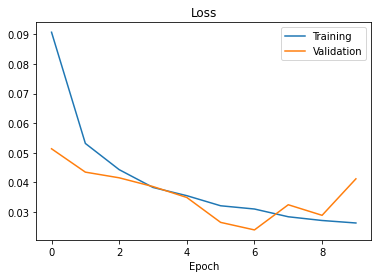

In [70]:
def eval_model(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training','Validation'])
    plt.title('Loss')
    plt.xlabel('Epoch')
  
eval_model(history)

In [20]:
history=model.fit(create_batch(X_train,y_train,batch_size=128),steps_per_epoch=300,epochs=5,validation_data=create_batch(X_test,y_test,augment=False),validation_steps=5)
model.save(os.path.join('models',f'v4.8_{dataset} batch size = 128.h5'))

Epoch 1/5
300/300 [==============================] - 153s 511ms/step - loss: 0.0454 - val_loss: 0.0421
Epoch 2/5
300/300 [==============================] - 141s 471ms/step - loss: 0.0445 - val_loss: 0.0423
Epoch 3/5
300/300 [==============================] - 143s 479ms/step - loss: 0.0428 - val_loss: 0.0561
Epoch 4/5
300/300 [==============================] - 145s 486ms/step - loss: 0.0422 - val_loss: 0.0418
Epoch 5/5
300/300 [==============================] - 142s 475ms/step - loss: 0.0399 - val_loss: 0.0394


## Testing the model

In [71]:
eval_imgs, actual_steering = next(create_batch(X_test,y_test,128,augment=False))

model_name = []
model_rmse = []


for model in glob.glob(os.path.join('models','***.h5')):
    eval_model = load_model(model)
    try:
        predicted_steering = eval_model.predict(eval_imgs)[:,0]
        rmse = np.sqrt(np.square(np.subtract(actual_steering,predicted_steering)).mean())
        
        model_name.append(os.path.split(model)[-1])
        model_rmse.append(rmse)
        #print(os.path.split(model)[-1],rmse)
    except:
        print(os.path.split(model)[-1], 'incompatiable with dataset')

data = {'Model':model_name,
        'RMSE':model_rmse}

df = pd.DataFrame(data)
print(df.head(200))


    

                                           Model      RMSE
0                            v3_less_training.h5  0.342526
1                              v4.6_new_model.h5  0.297269
2                      v4.7_N64_Mario_Raceway.h5  0.206944
3           v4.8_N64_Mario_Raceway size = 128.h5  0.187491
4   v4.8_N64_Mario_Raceway test more training.h5  0.200866
5                 v4.8_N64_Mario_Raceway test.h5  0.200366
6                      v4.8_N64_Mario_Raceway.h5  0.180752
7            v4.9_N64_Mario_Raceway size = 32.h5  0.192415
8            v4.9_N64_Mario_Raceway size = 64.h5  0.183330
9                v4.9_N64_Mario_Raceway small.h5  0.186903
10                                         v7.h5  0.337640
11                                 v7_dropout.h5  0.347508
12                                    v8_wasd.h5  0.343018


In [72]:
seed = random.randint(0,len(X_test)-16)
for img in X_test[seed:seed+8]:
    test_img = preProcessing(mpimg.imread(img))    
    steering = model.predict(np.asarray([test_img]))[0][0]
    plt.title(f'Steering = {steering}')
    plt.imshow(test_img)
    plt.show()



AttributeError: 'str' object has no attribute 'predict'